<hr style="height: 1px;">
<i>This notebook was authored by the 8.316x Course Team, Copyright 2023 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

<h1>Lesson 8: Fitting Neutrino Data</h1>


<a name='section_8_0'></a>
<hr style="height: 1px;">


## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L8.0 Overview</h2>


<h3>Navigation</h3>

<table style="width:100%">
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_8_1">L8.1 Neutrino Oscillations</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_8_1">L8.1 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_8_2">L8.2 Loading the Data</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_8_2">L8.2 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_8_3">L8.3 Fitting the Master Function to the Data</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_8_3">L8.3 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_8_4">L8.4 Principal Component Analysis</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_8_4">L8.4 Exercises</a></td>
    </tr>
</table>



<h3>Learning Objectives</h3>

In this Lesson we will consider the following questions:

- Why Do Neutrinos Oscillate?
- What does this mean in terms of mesurement?

We will also briefly explore the topic of principal component analysis.


In [2]:
#>>>RUN: L8.0-runcell02

import numpy as np                 #https://numpy.org/doc/stable/
from scipy import optimize as opt  #https://docs.scipy.org/doc/scipy/reference/optimize.html
import matplotlib.pyplot as plt    #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
import lmfit                       #https://lmfit.github.io/lmfit-py/ 
import scipy.stats as stats        #https://docs.scipy.org/doc/scipy/reference/stats.html
import uproot                      #https://uproot.readthedocs.io/en/latest/
from sklearn.decomposition import PCA                   #https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.datasets import fetch_lfw_people           #https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html
from sklearn.decomposition import PCA as RandomizedPCA  
from astroML.datasets import sdss_corrected_spectra

<a name='section_8_4'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L8.4 Principal Component Analysis</h2>     

| [Top](#section_8_0) | [Previous Section](#section_8_3) | [Exercises](#exercises_8_4) |


<h3>Overview</h3>

Finally, I would like to say that this method of finding the ellipse is our first deep learning method.
This procedure of computing the covariance matrix, and finding the eigenvectors is known as  principal component analysis or PCA. Let's run it on our example and look from <a href="https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html" target="_blank">Python Data Science Handbook by Jake VanderPlas</a>.

First, what we can do is look at our old correlated fit. All this will do is get the eigenvectors and values for our 2D plot.

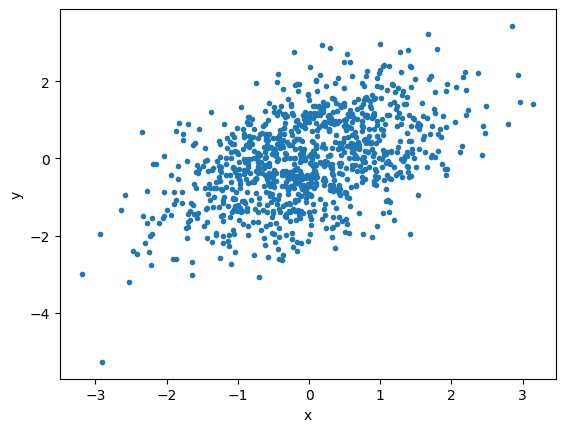

PCA vectors
[[-0.59606874 -0.80293341]
 [-0.80293341  0.59606874]]
PCA values
[1.70555459 0.56293186]
Old Eigen vectors [0.56293186 1.70555459] values [[-0.80293341 -0.59606874]
 [ 0.59606874 -0.80293341]]


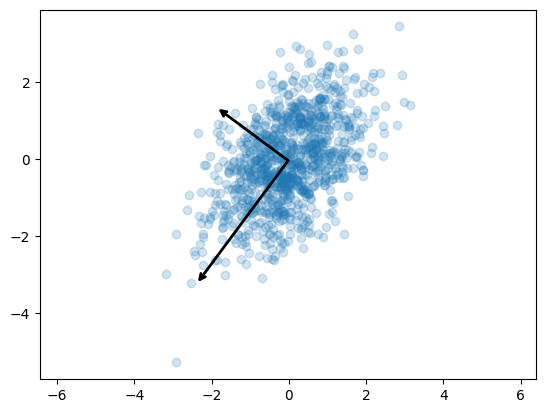

In [3]:
#>>>RUN: L8.4-runcell01
import numpy as np
from sklearn.decomposition import PCA
import numpy.linalg as la
#make some toy data
lAs = np.random.normal(0,1,1000)
lBs = np.random.normal(0,1,1000)+0.5*lAs
#print(lAs)

cov = np.cov([lAs,lBs])
#eigen cov
w, v=la.eig(cov)


plt.plot(lAs,lBs,".")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

X=(np.vstack([lAs,lBs])).T
pca = PCA(n_components=2)
pca.fit(X)
print("PCA vectors")
print(pca.components_)
print("PCA values")
print(pca.explained_variance_)
print("Old Eigen","vectors",w,"values",v)

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',linewidth=2,shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(lAs, lBs, alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

Finally, we can try this on an ML dataset. Let's take images with many pixels and treat each pixel as a separate dimension. We can then run the decomposition on the image by decomposing the n-pixel by n-pixel correlation matrix. What we will do is take an image that is 62x47=2914 Pixels. From that we can compute the covariance matrix and we can start to diagonlize this. Since this is a large matrix (2914x2914), we have to use sophisticaed eigen decomposition strategies. In this case, we will use something called RandomizedPCA. 

What we are going to do is run PCA on the images, and take the top 200 eigenvectors from that. Then we are going to plot the top few of these eigen vectors and the cumulative explained variance, which is a metric for how much information can be gained by adding dimensions. 

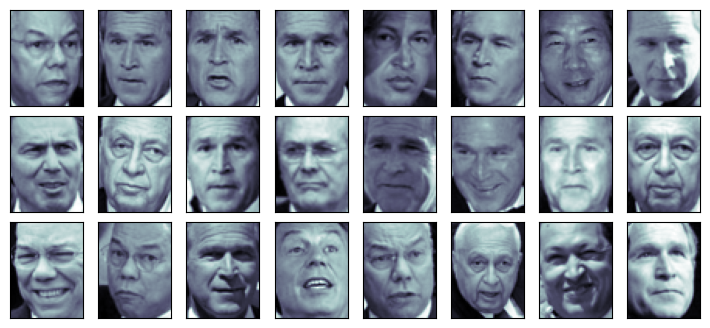

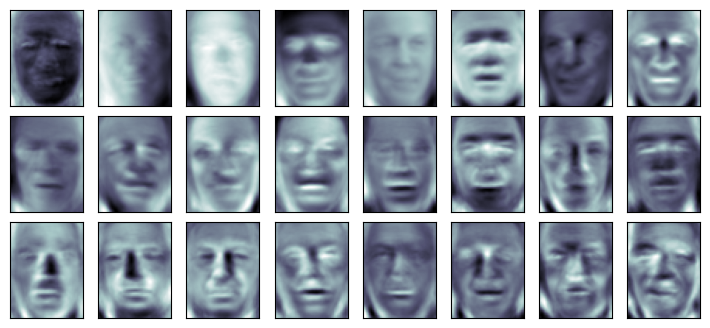

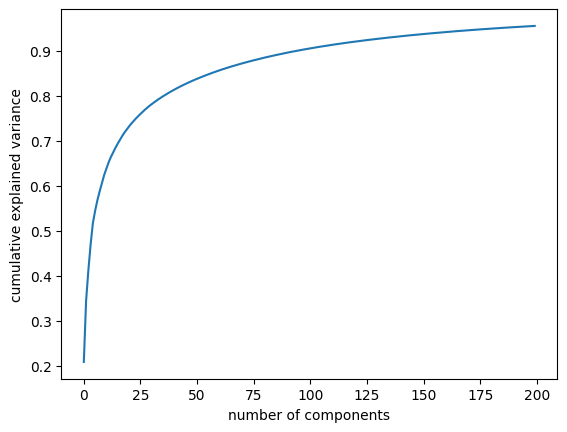

In [4]:
#>>>RUN: L8.4-runcell02

#Now let's do it ML style for fun
#Load some faces of images
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)

fig, axes = plt.subplots(3, 8, figsize=(9, 4),subplot_kw={'xticks':[], 'yticks':[]},gridspec_kw=dict(hspace=0.1, wspace=0.1))
#Let's plot the eigenvectors
for i, ax in enumerate(axes.flat):
    ax.imshow(faces.data[i].reshape(62, 47), cmap='bone')
#print(62*47)
#a
#Fit them to PCA 
from sklearn.decomposition import PCA as RandomizedPCA
pca = RandomizedPCA(200)
pca.fit(faces.data)
fig, axes = plt.subplots(3, 8, figsize=(9, 4),subplot_kw={'xticks':[], 'yticks':[]},gridspec_kw=dict(hspace=0.1, wspace=0.1))
#Let's plot the eigenvectors
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')
plt.show()
    
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()


What you can see above is that the top eigen vectors capture the shape of the face. You can see the shape variations between the different eigenvectors as you go through. Youc an see also that about 80% of the total info in the first 200 eigenvectors is captures in the first 25 components. 

Finally, what we can do is plot our world leaders just by taking the first 80 eigenvectors of our sample. What we have effectively done is compress our original image into just 80 values, thats all!

In [ ]:
#>>>RUN: L8.4-runcell03

# Compute the components and projected faces
pca = RandomizedPCA(10).fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),subplot_kw={'xticks':[], 'yticks':[]},gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('80-dim\nreconstruction');


<h3>Exercise using stellar spectra</h3>

As a final exercise, we are going to isolate features from stellar spectra of the Sloan Digit Sky Survey. To that, let's first load data from the SDSS and try to understand what this looks like. We will use the `astroML` package, that allows us to pull astro data quickly. 

From this data, we will look at redshift correct galaxy spectra. The correction allows us to look at the large population of galaxies in this dataset and try to find the dominant features. Let's take a quick look at the data. 

In [ ]:
#>>>RUN: L8.4-runcell04

from astroML.datasets import sdss_corrected_spectra

data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)
spectra_raw = data['spectra']
count=-1
#let's plot this guy
fig, ax = plt.subplots(2, 10, figsize=(20, 5.5),subplot_kw={'yticks':[]},gridspec_kw=dict(hspace=0.1, wspace=0.1))
nrows = 2; ncols = 10
for i in range(ncols):
    for j in range(nrows):
        count=count+1
        ax[j,i].plot(wavelengths,spectra_raw[count], '-k', lw=1)
        ax[j,i].set_xlim(3100, 7999)
        if j < nrows - 1:
            ax[j,i].xaxis.set_major_formatter(plt.NullFormatter())
        else:
            ax[j,i].set_xlabel(r'wavelength $(\AA)$')
            
plt.show()


What you see is that the spectra vary, but there are a few lines from the galaxies that are particularly bright. Look at the one above 6000 Angstroms. That the Hydrogen, $\beta$ emission line. You can see the whole table of lines <a href="http://astronomy.nmsu.edu/drewski/tableofemissionlines.html" target="_blank">here</a>.

In the following problem, we will look closely at the dominant eigenvector and identify any spectral lines that it might include.

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-8.4.1</span>

Your task is run PCA, look at the dominant eigenvector, and find the top two spectral lines. What do they correspond to (refer to the table <a href="http://astronomy.nmsu.edu/drewski/tableofemissionlines.html" target="_blank">here</a>.)?

Select two spectral lines from the options below (in units of angstroms):

- He ~4200
- H$\gamma$ ~4350
- H$\beta$ ~4860
- O III ~4950
- O III ~5006
- H$\alpha$ ~6560
- N II ~6580
- O I ~7000

Does this make sense?


In [ ]:
#>>>EXERCISE: L8.4.1

# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.
from astroML.datasets import sdss_corrected_spectra

data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)
spectra_raw = data['spectra']

#select only the first 850 bins to avoid noise features
spectra_raw = spectra_raw[:,0:850]
wavelengths = wavelengths[0:850]
pca = RandomizedPCA()


#YOUR CODE HERE
#fit the pca to the spectra_raw data 
#plot the first eigenvector, pca.components_[0] over the full range of wavelengths
#optionally constrain the wavelength range to zoom in on spectral lines

In [ ]:
#>>>SOLUTION: L8.4.1

from astroML.datasets import sdss_corrected_spectra

data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)
spectra_raw = data['spectra']
spectra_raw = spectra_raw[:,0:850]
wavelengths = wavelengths[0:850]

pca = RandomizedPCA()
pca.fit(spectra_raw)
plt.plot(wavelengths,pca.components_[0] , '-k', lw=1)
plt.xlabel(r'wavelength $(\AA)$')
#plt.xlim(6500,7000)
plt.show()

#print(wavelengths,pca.components_)
#print(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()


<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>

- O III ~5006
- H$\alpha$ ~6560

</pre>
        
**EXPLANATION:**
    
These emissions lines are famous lines from Oxygen and Hydrogen. See for example <a href="https://en.wikipedia.org/wiki/Doubly_ionized_oxygen" target="_blank">here</a>.
    
</div>


>#### Follow-up 8.4.1a (ungraded)
>
>Plot all of the eigenvectors. What are the dominant features of each?

In [ ]:
#>>>SOLUTION: L8.4.1

#Now let's look at the top 100 eigen vectors 
count=-1
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,bottom=0.1, top=0.95, hspace=0.05)
nrows = 10; ncols = 10
for i in range(ncols):
    for j in range(nrows):
        count=count+1
        ax = fig.add_subplot(nrows, ncols, ncols * j + 1 + i)
        ax.plot(wavelengths,pca.components_[count] , '-k', lw=1)
        ax.set_xlim(3100, 7999)

        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        if j < nrows - 1:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        else:
            plt.xlabel(r'wavelength $(\AA)$')
plt.show()

In [ ]:
components = pca.transform(spectra_raw)
projected = pca.inverse_transform(components)

# Plot the results
fig, ax = plt.subplots(2, 5, figsize=(20, 10),subplot_kw={'xticks':[], 'yticks':[]},gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(5):
    ax[0,i].plot(wavelengths,spectra_raw[count], '-k', lw=1)
    ax[0,i].set_xlim(3100, 7999)
    ax[1,i].plot(wavelengths,projected[count], '-k', lw=1)
    ax[1,i].set_xlim(3100, 7999)
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('80-dim\nreconstruction');


<a name='section_8_1'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L8.1 Neutrino Oscillations</h2>  

| [Top](#section_8_0) | [Previous Section](#section_8_0) | [Exercises](#exercises_8_1) | [Next Section](#section_8_2) |


<h3>Slides</h3>

Run the code below to view the slides for this section, which are discussed in the related video. You can also open the slides in a separate window <a href="https://mitx-8s50.github.io/slides/L08/slides_L08_01.html" target="_blank">HERE</a>.

In [ ]:
#>>>RUN: L8.1-slides

from IPython.display import IFrame
IFrame(src='https://mitx-8s50.github.io/slides/L08/slides_L08_01.html', width=970, height=550)

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-8.1.1</span>

For a neutrino beam that has a detector 1000km away, like is present with the DUNE neutrino experiment, what is the optimal energy (in GeV) to observe muon neutrino disappearance given a neutrino energy > 0.5 GeV?

Use the master formula below, which outputs the probability of oscillating from a muon neutrino to a muon neutrino, as a function of energy (in units of GeV). Find the minimum of the function to determine where the muon neutrino disappears.

Enter your answer as a number with precision 1e-2. 

In [4]:
#>>>EXERCISE: L8.1.1
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

def master_formula(E,L=1000):
    deltam=1*1e-3
    sin2theta23=0.57
    xval=1.27*deltam*L/E
    #val=1-4*scale2*sin2theta23*(1-scale2*sin2theta23)*np.sin(xval)**2
    val=1-4*sin2theta23*(1-sin2theta23)*(np.sin(xval)**2)
    return val



Minimum Energy is  0.8100000000000003


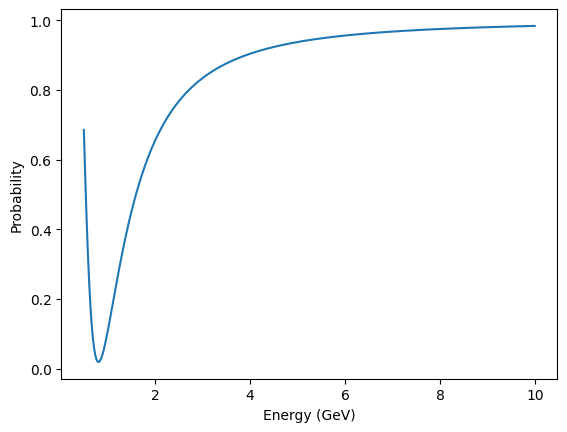

Text(0.5, 0, 'Distance')

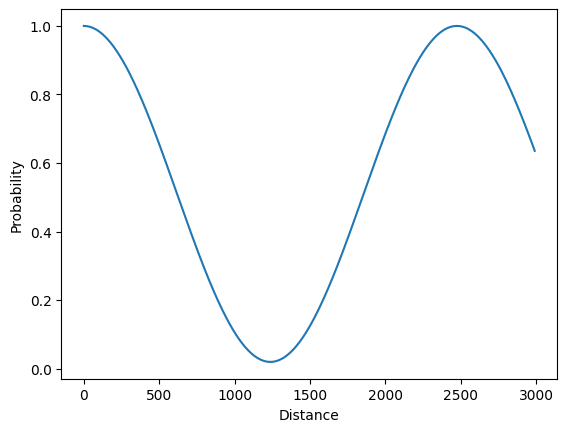

In [5]:
#>>>SOLUTION: L8.1.1

def master_formula(E,L=1000):
    deltam=1*1e-3
    sin2theta23=0.57
    xval=1.27*deltam*L/E
    #val=1-4*scale2*sin2theta23*(1-scale2*sin2theta23)*np.sin(xval)**2
    val=1-4*sin2theta23*(1-sin2theta23)*(np.sin(xval)**2)
    return val

evals=np.arange(0.5,10,0.01)
mixvals=master_formula(evals)
plt.plot(evals,mixvals)
plt.ylabel("Probability")
plt.xlabel("Energy (GeV)")
print("Minimum Energy is ",evals[np.argmin(mixvals)])
plt.show()

evals=np.arange(0,3000,10)
mixvals=master_formula(1,evals)
plt.plot(evals,mixvals)
plt.ylabel("Probability")
plt.xlabel("Distance")

<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
0.81 GeV 
</pre>
        
**EXPLANATION:**

We want to get the maximum amount of muon neutrino disappearance. This is done by finding the minium of the master formula over the full energy range. We see this minimum occurs at 0.81 GeV. Alternatively, we could have varied the length at a fixed energy. 
    
    
</div>


>#### Follow-up 8.1.1a (ungraded)
>
>What other parameters of this experiment could we vary to observe the neutrino disappearance?

<a name='section_8_2'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L8.2 Loading the Data</h2>  

| [Top](#section_8_0) | [Previous Section](#section_8_1) | [Exercises](#exercises_8_2) | [Next Section](#section_8_3) |


<h3>Fitting Neutrino data</h3>

In this part of the lecture, I would like to fit data from one of the recent neutrino experiments. The data consists of events at various energies that are observed from neutrino-matter interactions in the NO$\nu$A experiment in Minnesota. Details about this experiment can be found <a href="https://inspirehep.net/files/0a3cd74d55753d242b2a364ce70a5e0e" target="_blank">here</a>.

There are 3 type of neutrinos, the electron, muon and $\tau$ neutrino. These neutrinos all interact in roughly the same way, through the weak interaction. Additionally, these neutrinos are all known to be very light. Lastly, it is found that these neutrinos are capable of changing from one type to another over time. What that means is that an electron neutrino can oscillate into a muon neutrino or a $\tau$ neutrino, and so on. The fact that they oscillate is a bit of a mystery, but what we do know is that this means the way mass is generated for the neutrinos is a different mechanism to the way it interacts.  

To understand the data, we need to consider the key components of this experiment, which is that we first create a beam of neutrinos at Fermilab in Illinois, and we then fire this beam at the NO$\nu$A experiment in Minnesota. At NO$\nu$A we check to see what we observe. Since neutrinos interact very weakly, we do this by counting interactions of muon neutrinos in two separate detectors, one Fermilab and the other at NO$\nu$A. Between Fermilab and NO$\nu$A, some of these muon neutrinos will oscillate into other types of neutrino through quantum mechanical mixing. This is a great way to test the properties of quantum mechanics. You can read more about that <a href="https://arxiv.org/abs/1602.00041" target="_blank">here</a>.

That being said, what we expect to compare is the shape of the observed events from the input beam, with the shape of the output beam. Since neutrinos interact very weakly, the way we perform this is we put a large detector near the input beam, and we measure the rate of muon neutrinos, and then we put an even larger detector at the output beam, and we measure the rate. Let's take a look at this data. 

The data is in root format, like the project. We will use uproot to load the data and see what it is like. 

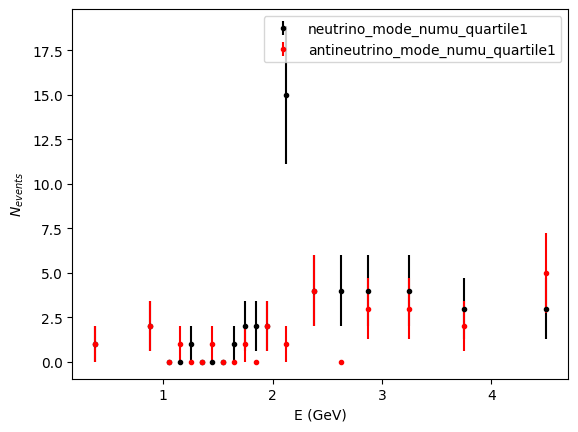

In [6]:
#>>>RUN: L8.2-runcell01

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import uproot

file = uproot.open("data/NOvA_2020_data_histograms.root")

#print(file.classnames())

def plot(iLabel,iFile,iColor):
    bin_edges = iFile[iLabel].axis().edges()
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    plt.xlabel("E (GeV)")
    plt.ylabel("$N_{events}$")
    plt.errorbar(bin_centers,iFile[iLabel].values(),yerr=iFile[iLabel].errors(),marker='.',linestyle = '', color = iColor,label=iLabel)    
    
plot("neutrino_mode_numu_quartile1",file,'black')
plot("antineutrino_mode_numu_quartile1",file,'red')
plt.legend()
plt.show()

    

So, we see two neutrino samples with four quartiles. The quartiles turn out to be different quality selections on the data. Quartile 1 is the most sensitive quartile, whereas Quartile 2, 3, and 4 are progressively less sensitive. How these quartiles are chosen depends on the beam, detector performance, and quality of the reconstruction. For our measurement, we can sum them all up and treat them as one measurement. 

The other label we see is the anti-neutrino and neutrino labels for the type of beam. The beam at Fermilab can be run in two different modes. One mode is neutrino mode. In this mode, particles are fired into the beam that mostly decay into regular neutrinos. The other mode is anti-neutrino mode, in that scenario particles are fired into the beam that decay into anti-neutrinos. 

Suffice it to say there is no guarantee that anti-neutrinos and neutrinos oscillate in the same way, so we keep these samples separate. We can look at the separate quartiles, but let's do that later. 

Instead, let's look at another root file that has the predictions for what we expect the neutrino beam to look like. 

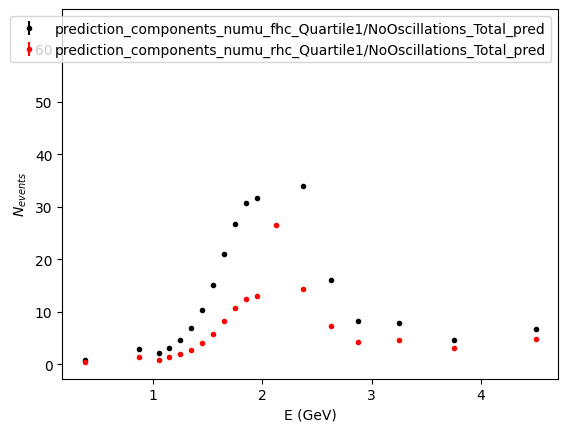

In [7]:
#>>>RUN: L8.2-runcell02

filePred = uproot.open("data/NOvA_2020_data_release_predictions_with_systs_all_hists.root")

#print(filePred.classnames())
plot("prediction_components_numu_fhc_Quartile1/NoOscillations_Total_pred",filePred,'black')
plot("prediction_components_numu_rhc_Quartile1/NoOscillations_Total_pred",filePred,'red')
plt.legend()
plt.show()

This file is messy. I won't go into the details but let me put some labels here, to reconcile things. First of all, we see prediction_components_rhc_Quartile. Quartile is the same as before. RHC, and its counterpart FHC standard for "Reverse Horn Current" (RHC) and "Foward Horn Current".   The FHC configuration focuses charged particles with positive polarity (pions, $\pi^{+}$ and Kaons, $K^{+}$) which decay to give a neutrino beam ($\nu_{\mu}$) whereas, the RHC configuration focuses charged particles with negative polarity (pions,$\pi^{-}$ and Kaons, $K^{-}$) that decay to give an anti-neutrino enhanced beam ($\bar{\nu}_{\mu}$). 

Furthermore, the predictions are done under the assumption that there are no oscillations. Hence, the "NoOscillations" label.

<h3>Neutrino Oscillations</h3>

To understand how to fit this data, we follow from the master formula for neutrino oscillations. For those familiar with quantum mechanics, let's write out what the neutrino particle eigen-state is:

$$
\begin{equation}
 |\nu_{\mu}\rangle = U^{*}_{\mu 1}|\nu_{1}\rangle + U^{*}_{\mu 2}|\nu_{2}\rangle + U^{*}_{\mu 3}|\nu_{3}\rangle
\end{equation}
$$

Where $U_{\mu i}$ is the muon row of the oscillation matrix. When you evolve each piece $i$ of this state over time $t$ and allow the neutrino of energy $E$ and mass $m_{i}$ to move forward a length $L$, you will get that (skipping some steps) 

$$
\begin{eqnarray}
 |\nu_{i}(L)\rangle = e^{-iEt-\vec{p}\cdot\vec{x}}|\nu_{i}\rangle \\
               \approx e^{-i\frac{Lm^{2}_{i}}{2E}}|\nu_{i}(L=0)\rangle
\end{eqnarray}
$$

and, thus, even for identical energies $E$, separate mass eigenstates $\nu_{1}$, $\nu_{2}$ and $\nu_{3}$ will evolve at different rates because of the $m_{i}$ term. What that means is that the probability for neutrinos to still be there can be written by the following master formula: 

$$
\begin{eqnarray}
 P_{\mu\rightarrow\mu} & = &  \left|\langle\nu_{\mu}(L)|\nu_{\mu}(0)\rangle\right|^{2} \\
                       & \approx & 1-\sin^{2}2\theta_{23}\sin^{2}\left(\frac{1.27\Delta m^{2}_{23}}{E} L\right) \\ 
                       & =       & 1-4(\sin^{2}\theta_{23})(1-\sin^{2}\theta_{23})\sin^{2}\left(\frac{1.27\Delta m^{2}_{23}}{E} L\right)  
\end{eqnarray}
$$

where $\sin^{2}\theta_{23}$ is the parameter that describes the rate of oscillation between muon neutrinos and $\tau$ neutrinos, and $m^{2}_{23}=m_{3}^2-m_{2}^2$ is the mass difference between the $\tau$ and muon neutrino. You may ask, why is the electron neutrino not involved. It turns out that its rate of oscillations is too small to impact this measurement. 

Given that, what we can do then is take our original data, divide it by our no oscillation expectation and fit it. In this case, what we would like to extract is not just one parameter, but two parameters $\theta_{23}$ and $m^{2}_{23}$. Let's see if we can get them. 

First, let's prepare our ratio data, starting by constructing the ratio for each quantile.


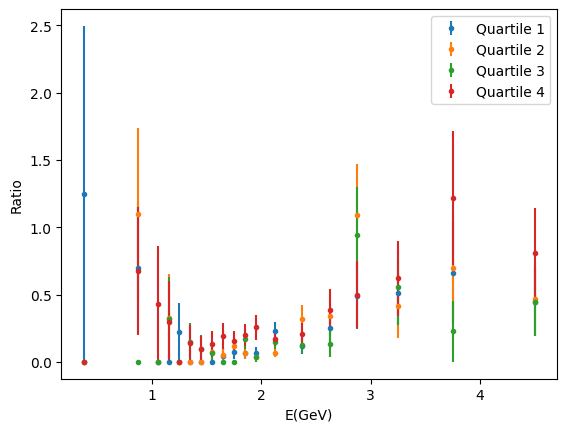

In [8]:
#>>>RUN: L8.2-runcell03

nquartiles=4
label="neutrino_mode_numu_quartile"
predlabel0="prediction_components_numu_fhc_Quartile"
predlabel1="/NoOscillations_Total_pred"
bin_edges=file[label+"1"].axis().edges()
x = 0.5*(bin_edges[1:] + bin_edges[:-1])
def ratio(iQuartile,iPlot=False):
    ytop=file[label+str(i0+1)].values()
    #ytop_err=file[label+str(i0+1)].values()
    ytop_err=np.sqrt(file[label+str(i0+1)].values())
    ybot=filePred[predlabel0+str(i0+1)+predlabel1].values()
    #ybot_err=file[label+str(i0+1)].values() we will skip this since the error is much smaller
    y = ytop/ybot
    y_err = ytop_err/ybot #we will ignore the ybot error since it is tiny
    if iPlot:
        plt.errorbar(x,y,yerr=y_err,marker='.',linestyle = '',label="Quartile "+str(i0+1))
    return y,y_err
    
for i0 in range(nquartiles):
    ratio(i0,True)
    
plt.xlabel("E(GeV)")
plt.ylabel("Ratio")
plt.legend()
plt.show()

Now, what we would like to do is combine these ratios together. However, we need to do an average weighted by their uncertainties. To do that, we will define for the i-th bin in the ratio $r_{i}$ for the j-th quartile, the <a href="https://en.wikipedia.org/wiki/Weighted_arithmetic_mean" target="_blank">weighted mean</a>

$$
\begin{equation}
 \bar{r}_{i} = \frac{1}{\sum_{j=1}^{4} \frac{1}{\sigma^{2}_{ij}} }\sum_{j=1}^{4} \frac{1}{\sigma^{2}_{ij}} r_{ij}
\end{equation}
$$

This is the maximum likelihood mean for normally distributed independent variables (see above). The weighted variance is then given by propagation of errors as

$$
\begin{equation}
 \sigma^{2}_{i} = \left(\frac{1}{\sum_{j=1}^{4} \frac{1}{\sigma^{2}_{ij}} }\right)^{2}\sum_{j=1}^{4} \frac{1}{\sigma^{4}_{ij}} \sigma^{2}_{ij} \\
  \sigma^{2}_{i} = \left(\frac{1}{\sum_{j=1}^{4} \frac{1}{\sigma^{2}_{ij}} }\right)^{2}\sum_{j=1}^{4} \frac{1}{\sigma^{2}_{ij}} \\
\sigma^{2}_{i} = \left(\frac{1}{\sum_{j=1}^{4} \frac{1}{\sigma^{2}_{ij}} }\right)
\end{equation}
$$

Let's go ahead and combine them.

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_85615/2318388019.py:9: RuntimeWarning: divide by zero encountered in divide
  weights=1./(y_err**2)


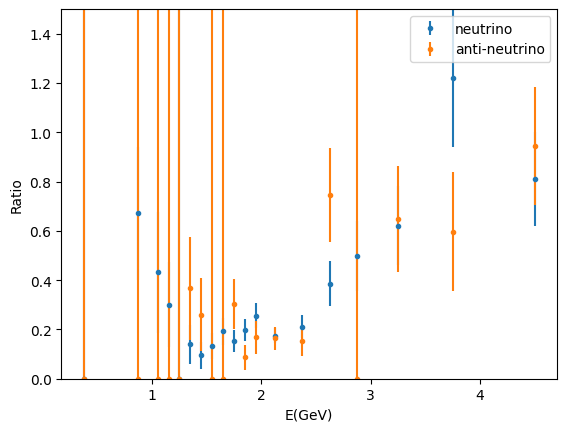

In [9]:
#>>>RUN: L8.2-runcell04
def combinedRatio():
    y,y_err = ratio(0,False)
    y_arrs=np.array([y])
    weight_arrs=np.array([y_err])
    for i0 in range(nquartiles-1):
        y,y_err = ratio(i0,False)
        y_arrs=np.vstack([y_arrs,y])
        weights=1./(y_err**2)
        weights[weights == np.inf] = 0.1
        weight_arrs = np.vstack([weight_arrs,weights])
    #Now do the weighted 
    yout=np.average(y_arrs,weights=weight_arrs,axis=0)
    weights=np.sum(weight_arrs,axis=0)
    return yout,1/weights**0.5,weights**0.5

label="neutrino_mode_numu_quartile"
predlabel0="prediction_components_numu_fhc_Quartile"
y,yerr,weights=combinedRatio()    

label="antineutrino_mode_numu_quartile"
predlabel0="prediction_components_numu_rhc_Quartile"
y_anti,yerr_anti,weights_anti=combinedRatio()    

plt.errorbar(x,y,yerr=yerr,marker='.',linestyle = '',label="neutrino")
plt.errorbar(x,y_anti,yerr=yerr_anti,marker='.',linestyle = '',label="anti-neutrino")
plt.xlabel("E(GeV)")
plt.ylabel("Ratio")
plt.legend()
plt.ylim(0,1.5)
plt.show()

<a name='exercises_8_2'></a>     

| [Top](#section_8_0) | [Restart Section](#section_8_2) | [Next Section](#section_8_3) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-8.2.1</span>

In this problem, we want to show that the weighted average with weight given by $\frac{1}{\sigma^2}$ minmizes the uncertainty. For this case, consider a weighted average of two numbers $x$ and $y$. We can define the weighted average $\bar{x}$ as 

$$\bar{x}=f x + (1-f) y$$

where $0 \leq f \leq 1$ is our weight factor. The uncertainty on $\bar{x}$ can be written as 


$$\sigma^2_{\bar{x}}=f^2 \sigma_{x}^2 + (1-f)^2 \sigma_{y}^2$$ 

To minimize the uncertainty all we need to do is 

$$ \frac{d\sigma_{\bar{x}}^2}{df} = 0$$

What is the value of $f$ that minimizes the uncertainty? Express your answer using `sigmax` for $\sigma_{x}$ and `sigmay` for $\sigma_{y}$.


<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**


$$ \frac{d\sigma_{\bar{x}}^2}{df} = 2f\sigma_{x}^2 - 2(1-f)\sigma_{y}^2 = 2f(\sigma_{x}^2+\sigma_{y}^2) - 2\sigma_{y}^2 = 0$$

$$ f = \frac{\sigma_{y}^2}{\sigma_{x}^2+\sigma_{y}^2} = \frac{\frac{1}{\sigma_{x}^2\sigma_{y}^2}}{\frac{1}{\sigma_{x}^2\sigma_{y}^2}} \frac{\sigma_{y}^2}{\sigma_{x}^2+\sigma_{y}^2} $$

$$ f = \frac{\frac{1}{\sigma_{x}^2}}{\frac{1}{\sigma_{y}^2} + \frac{1}{\sigma_{x}^2}} $$
        
**EXPLANATION:**
    
The point being is that weighting by $1/\sigma^2$ gives you the best weighted mean. 
    
</div>


>#### Follow-up 8.2.1a (ungraded)
>
>Show that this yields the weighted average formula that we previously derived. Try on your own, or see the solution to the problem above.
>
>Hint: You might have to multiply your final result by:
>
>$$\frac{\frac{1}{\sigma_{x}^2\sigma_{y}^2}}{\frac{1}{\sigma_{x}^2\sigma_{y}^2}}$$

<a name='section_8_3'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L8.3 Fitting the Master Function to the Data</h2>  

| [Top](#section_8_0) | [Previous Section](#section_8_2) | [Exercises](#exercises_8_3) | [Next Section](#section_8_4) |


<h3>Slides</h3>

Run the code below to view the slides for this section, which are discussed in the related video. You can also open the slides in a separate window <a href="https://mitx-8s50.github.io/slides/L08/slides_L08_03.html" target="_blank">HERE</a>.

In [ ]:
#>>>RUN: L8.3-slides

from IPython.display import IFrame
IFrame(src='https://mitx-8s50.github.io/slides/L08/slides_L08_03.html', width=970, height=550)

Ok, now that we have the points, let's finally fit the data.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 69
    # data points      = 17
    # variables        = 2
    chi-square         = 22.7339744
    reduced chi-square = 1.51559829
    Akaike info crit   = 8.94100120
    Bayesian info crit = 10.6074279
    R-squared          = -14.5179255
[[Variables]]
    scale1:  2.47409703 +/- 0.08263435 (3.34%) (init = 1)
    scale2:  0.33626994 +/- 0.01806023 (5.37%) (init = 0.6)
[[Correlations]] (unreported correlations are < 0.100)
    C(scale1, scale2) = -0.488
Fit1 chi2 probability:  0.08995372202501328
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 11
    # variables        = 2
    chi-square         = 12.4163640
    reduced chi-square = 1.37959600
    Akaike info crit   = 5.33232005
    Bayesian info crit = 6.12811059
    R-squared          = -14.2374647
[[Variables]]
    scale1:  2.82005486 +/- 0.18030751 (6.39%) (init = 1)
    scale2:  0.68011154 +/- 0.0244

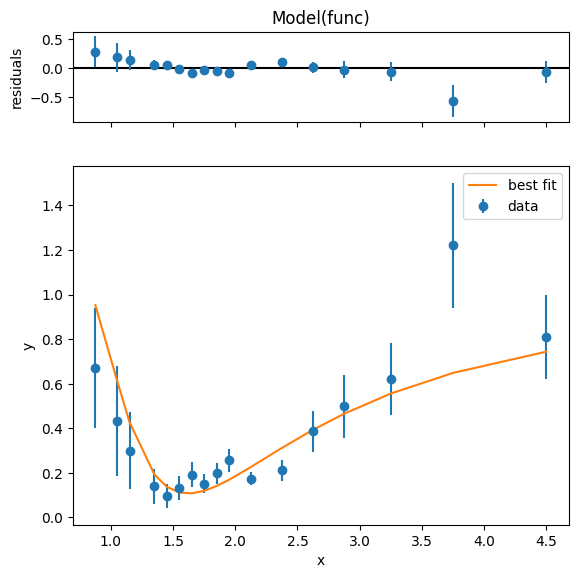

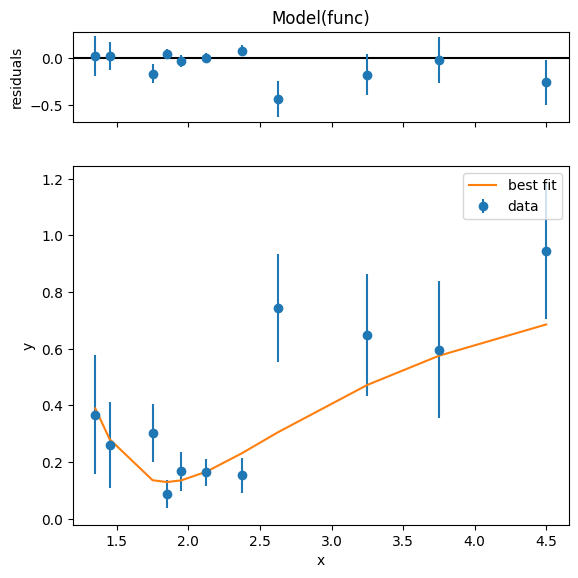

In [12]:
###Write your own Fit code stupid
import lmfit
#default values
deltam=1*1e-3
L=810
sin2theta23=1.0


fit(x,y,weights)
fit(x,y_anti,weights_anti)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 69
    # data points      = 17
    # variables        = 2
    chi-square         = 22.7339744
    reduced chi-square = 1.51559829
    Akaike info crit   = 8.94100120
    Bayesian info crit = 10.6074279
    R-squared          = -14.5179255
[[Variables]]
    scale1:  2.47409703 +/- 0.08263435 (3.34%) (init = 1)
    scale2:  0.33626994 +/- 0.01806023 (5.37%) (init = 0.6)
[[Correlations]] (unreported correlations are < 0.100)
    C(scale1, scale2) = -0.488
Fit1 chi2 probability:  0.08995372202501328
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 11
    # variables        = 2
    chi-square         = 12.4163640
    reduced chi-square = 1.37959600
    Akaike info crit   = 5.33232005
    Bayesian info crit = 6.12811059
    R-squared          = -14.2374647
[[Variables]]
    scale1:  2.82005486 +/- 0.18030751 (6.39%) (init = 1)
    scale2:  0.68011154 +/- 0.0244

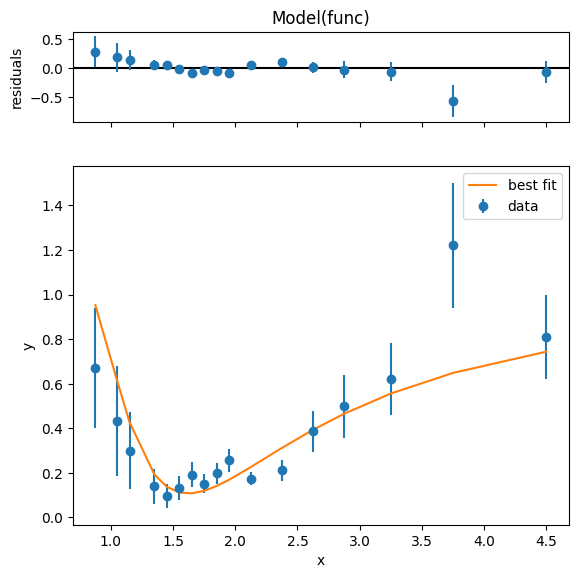

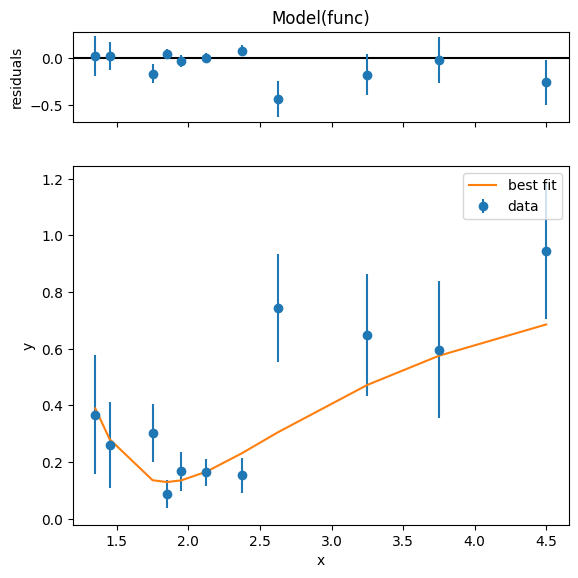

In [11]:
#>>>RUN: L8.3-runcell01

import lmfit
deltam=1*1e-3
L=810
sin2theta23=1.0
def func(x,scale1,scale2):
    xval=1.27*deltam*scale1*L/x
    #val=1-4*scale2*sin2theta23*(1-scale2*sin2theta23)*np.sin(xval)**2
    val=1-4*scale2*(1-scale2)*(np.sin(xval)**2)
    return val

def fit(iX,iY,iWeight):
    model  = lmfit.Model(func)
    p = model.make_params(scale1=1.0,scale2=0.6)
    result = model.fit(x=iX[iY > 0],data=iY[iY > 0], params=p, weights=iWeight[iY > 0])
    lmfit.report_fit(result)
    result.plot()
    print("Fit1 chi2 probability: ",1-stats.chi2.cdf(result.chisqr,result.nfree))

fit(x,y,weights)
fit(x,y_anti,weights_anti)

<h3>Profiling Neutrino Parameters</h3>

So, we see that neutrinos oscillate. However, what if we want to understand how the values of the parameters vary. Let's do a quick scan of the parameters, computing the likelihood for each. 

We can write the 2 times the log likelihood in terms of the $\chi^{2}$: 


$$
\begin{eqnarray}
\chi^{2}(x|\vec{\theta}) &=& \sum_{i=1}^{N} \frac{(x_{i}-f(x_{i}|\vec{\theta}))^2}{\sigma_{i}^{2}} \\
-2 \log\left(\mathcal{L}(x|\vec{\theta})\right) &=& \sum_{i=1}^{N} \frac{(x_{i}-f(x_{i}|\vec{\theta}))^2}{\sigma_{i}^{2}} \\
\end{eqnarray}
$$

In [ ]:
def twoLogLike(var,iX=x,iY=y,iWeights=weights):

    
from scipy import optimize as opt
x0 = np.array([1,1])
sol=opt.minimize(twoLogLike, x0)

def plotScan(sol):

plotScan(sol)

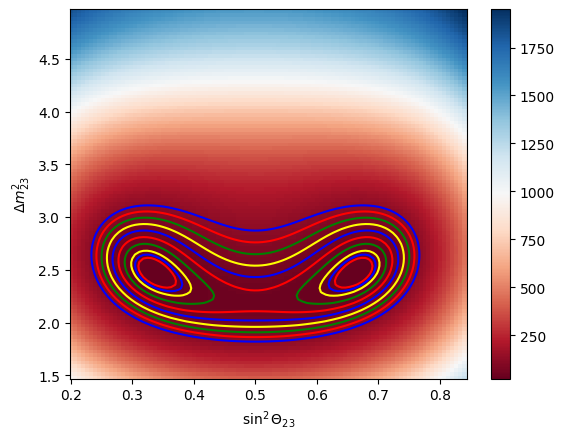

In [13]:
#>>>RUN: L8.3-runcell02

def twoLogLike(var,iX=x,iY=y,iWeights=weights):
    lTot=0
    xtest=func(iX,var[1],var[0])
    lTot = weights*(iY-xtest)
    return np.sum(lTot**2)

from scipy import optimize as opt
x0 = np.array([1,1])
sol=opt.minimize(twoLogLike, x0)

def plotScan(sol):
    #Look the same answers, now let's plot the chi2
    xscan = np.linspace(sol.x[0]*0.6,sol.x[0]*2.5, 100)
    yscan = np.linspace(sol.x[1]*0.6,sol.x[1]*2.0, 100)
    X, Y = np.meshgrid(xscan, yscan)
    #levels = [0.1,1,2.3,4,9, 16, 25, 36, 49, 64, 81, 100]
    levels = [4,6,9, 16, 25, 36, 49, 64, 81, 100]
    for i0 in range(len(levels)):
        levels[i0] = levels[i0]+sol.fun
    Z = np.array([twoLogLike([xscan,yscan]) for (xscan,yscan) in zip(X.ravel(), Y.ravel())]).reshape(X.shape)
    fig, ax = plt.subplots(1, 1)
    c = ax.pcolor(X,Y,Z,cmap='RdBu')
    fig.colorbar(c, ax=ax)
    c = plt.contour(X, Y, Z, levels,colors=['red', 'blue', 'yellow','green'])
    plt.xlabel("$\sin^{2}\Theta_{23}$")
    plt.ylabel("$\Delta m^{2}_{23}$")
    plt.show()

plotScan(sol)

So now, we see two circles. What exactly does this mean? Let's profile one variable at a time. First we can look at a profile of $\sin^{2}\theta_{23}$ for the case where we mix $\Delta m^{2}_{23}$ to the best fit value. Then we can do the opposite, fixing $\sin^{2}\theta_{23}$ to one of the two minima and profiling  $\Delta m^{2}_{23}$.


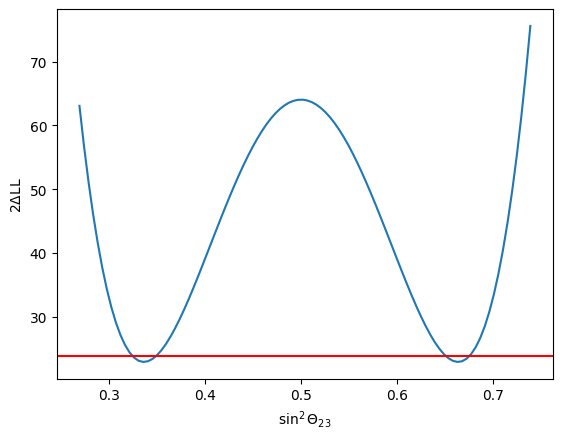

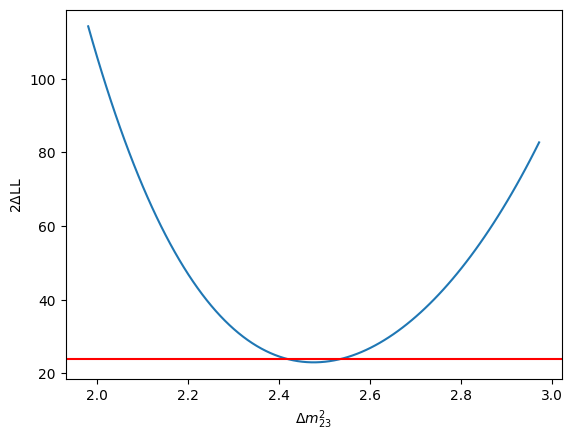

In [14]:
#>>>RUN: L8.3-runcell03

#Now let's fix one parameter at the minimum, and profile the other
def scanAxes(sol):
    xscan = np.linspace(sol.x[0]*0.8,sol.x[0]*2.2, 100)
    yscan = np.linspace(sol.x[1]*0.8,sol.x[1]*1.2, 100)

    xLog = np.array([])
    for pX in xscan:
        xLog = np.append(xLog,twoLogLike(var=[pX,sol.x[1]]))

    yLog = np.array([])
    for pY in yscan:
        yLog = np.append(yLog,twoLogLike(var=[sol.x[0],pY]))

    plt.plot(xscan, xLog,label='loglike');
    plt.axhline(sol.fun+1, c='red')
    plt.xlabel("$\sin^{2}\Theta_{23}$")
    plt.ylabel("2$\Delta$LL")
    plt.show()

    #Now for the other parameter
    plt.plot(yscan,yLog,label='LL');
    plt.axhline(sol.fun+1, c='red')
    plt.xlabel("$\Delta m^{2}_{23}$")
    plt.ylabel("2$\Delta$LL")
    plt.show()
    
scanAxes(sol)

So, for $\sin^{2}(\theta_{23})$ there are actually two minima that have the same minimal value. This is a degeneracy in the ways neutrinos oscillate that this data cannot resolve. 

This is a complex fit that is hard to  intepret. Let's do the scan for anti-neutrino to see if a difference in parameters between anti and regular neutrino.  A difference in the parameters would mean that anti particles behave differently that regular particles. This is known as <a href="https://en.wikipedia.org/wiki/CP_violation" target="_blank">CP-violation</a> and can possibly explain why the universe is made of predominatly matter!

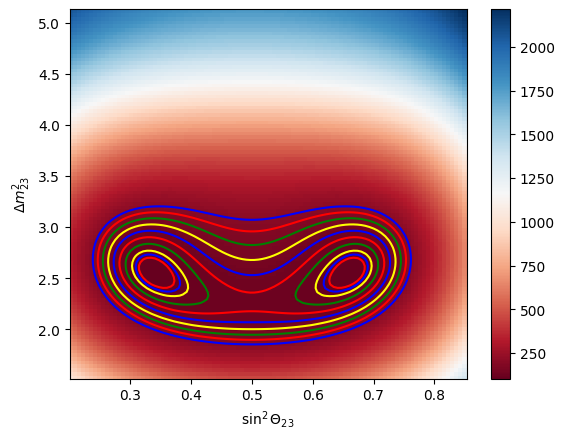

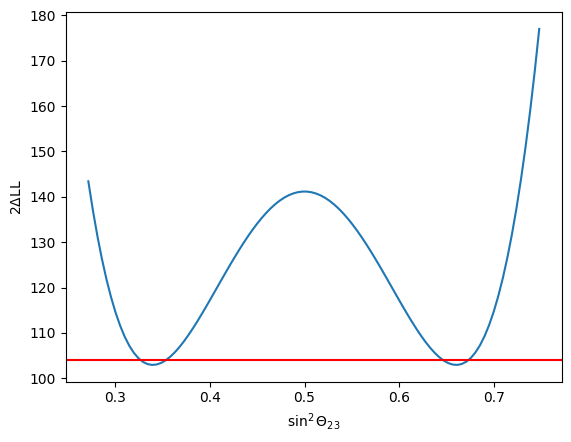

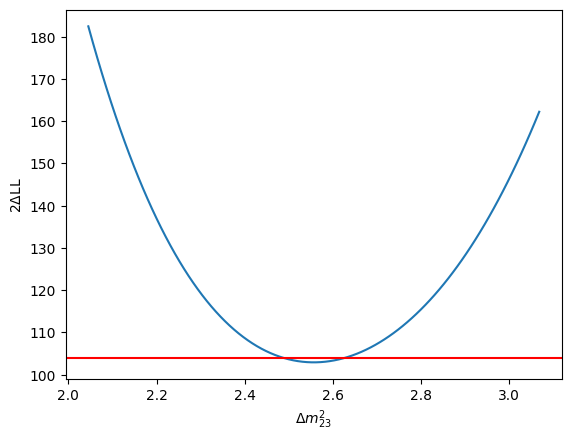

In [15]:
#>>>RUN: L8.3-runcell04

#answer
def twoLogLike(var,iX=x,iY=y_anti,iWeights=weights_anti):
    lTot=0
    xtest=func(iX,var[1],var[0])
    lTot = weights*(iY-xtest)
    return np.sum(lTot**2)

x0 = np.array([1,1])
sol=opt.minimize(twoLogLike, x0)
plotScan(sol)
scanAxes(sol)

These look almost exactly like the regular neutrino, so sadly we don't see any CP-violation.

<h3>Combining measurements with constraints from the world</h3>

Now, let's say we want to combine this measurement with another measurement. The simplest way to imagine this is that we are minimizing our fit with an additional bin, which is the likelihood that our measurement has deviated from the world average. Our likelihood now will be the product of the probabilities of the best fit parameters, with the new results from NO$\nu$A.  We can write this as


$$
\begin{equation}
-2 \log\left(\mathcal{L}(x|\vec{\theta})\right) = -2 \log\left(\mathcal{L}(x|\vec{\theta})\right)_{\rm original} + 
\frac{\left(\sin \theta_{23} - \sin \theta_{23}^{\rm best}\right)^{2}}{\sigma^{2}_{\sin \theta_{23}}} + \frac{\left(\Delta m^{2}_{23} - \Delta m^{2~\rm{best}}_{23}\right)^{2}} {\sigma^{2~\rm{best}}_{\Delta m^{2}_{12}}}
\end{equation}
$$

This is just equivalent to multiplying the p-values of our fit with a gaussian about the best fit parameters.

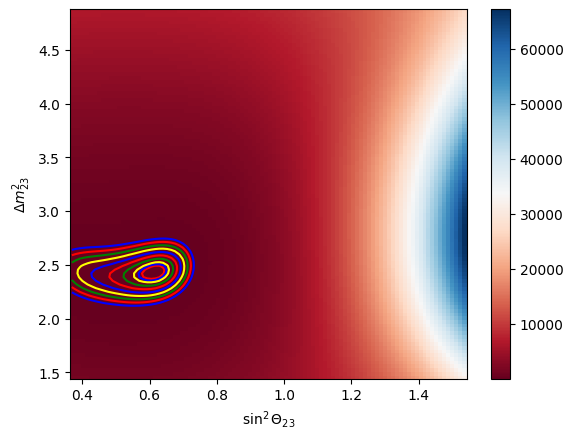

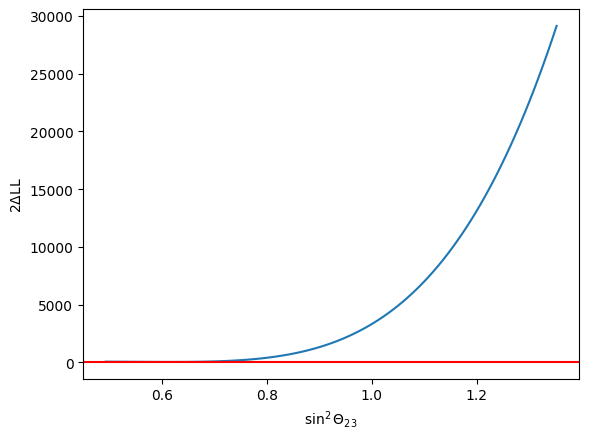

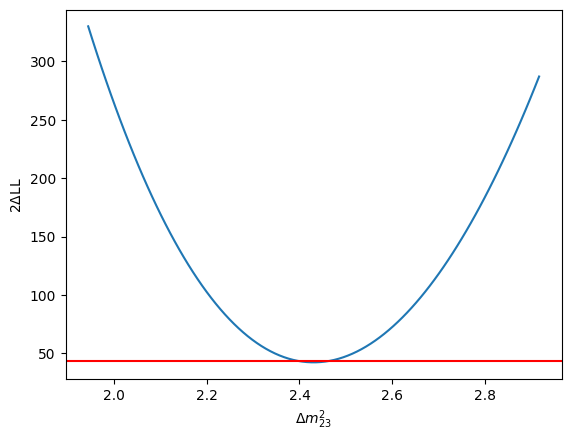

In [16]:
#>>>RUN: L8.3-runcell05

#Now what if we try to add the world's measurement of these parameters into our fit
#https://pdg.lbl.gov/2020/listings/rpp2020-list-neutrino-mixing.pdf
def twoLogLike(var,iX=x,iY=y,iWeights=weights):
    lTot=0
    xtest=func(iX,var[1],var[0])
    lTot = weights*(iY-xtest)
    lTot = np.sum(lTot**2)
    sin2worldavg=0.547
    sin2uncavg=0.021
    constraintsin2=((var[0]-sin2worldavg)**2)/(sin2uncavg**2)
    deltamworldavg=2.453
    deltamuncavg=0.034
    constraintdeltam=((var[1]-deltamworldavg)**2)/(deltamuncavg**2)
    return lTot+constraintsin2+constraintdeltam

x0 = np.array([1,1])
sol=opt.minimize(twoLogLike, x0)
plotScan(sol)
scanAxes(sol)

Now you can see that the degneracy is resolved and the best fit parameters are tightly constrained to a very specific set of parameters. Now, we can go ahead and zoom in our best fit set of parameters. 

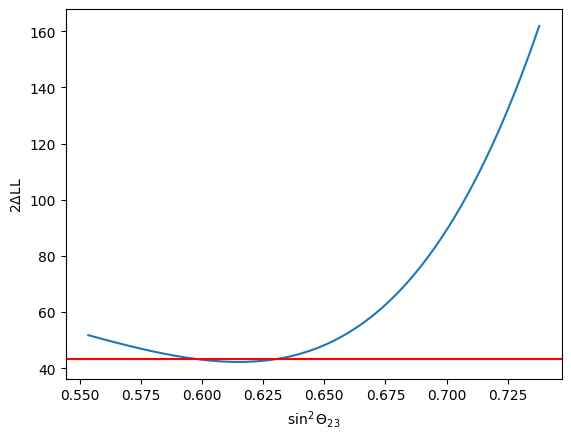

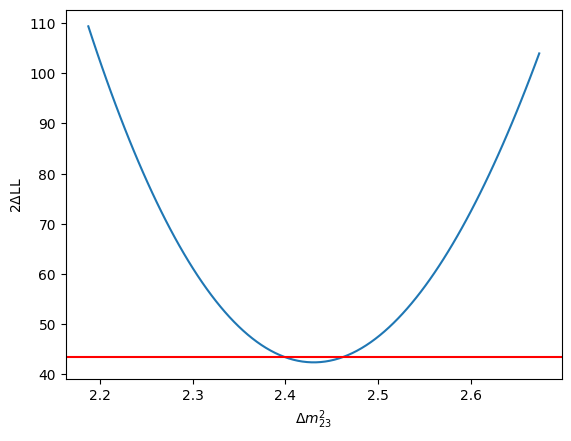

In [17]:
#>>>RUN: L8.3-runcell06

def scanAxes(sol):
    xscan = np.linspace(sol.x[0]*0.9,sol.x[0]*1.2, 100)
    yscan = np.linspace(sol.x[1]*0.9,sol.x[1]*1.1, 100)

    xLog = np.array([])
    for pX in xscan:
        xLog = np.append(xLog,twoLogLike(var=[pX,sol.x[1]]))

    yLog = np.array([])
    for pY in yscan:
        yLog = np.append(yLog,twoLogLike(var=[sol.x[0],pY]))

    plt.plot(xscan, xLog,label='loglike');
    plt.axhline(sol.fun+1, c='red')
    plt.xlabel("$\sin^{2}\Theta_{23}$")
    plt.ylabel("2$\Delta$LL")
    plt.show()

    #Now for the other parameter
    plt.plot(yscan,yLog,label='LL');
    plt.axhline(sol.fun+1, c='red')
    plt.xlabel("$\Delta m^{2}_{23}$")
    plt.ylabel("2$\Delta$LL")
    plt.show()
    
scanAxes(sol)

<a name='exercises_8_3'></a>     

| [Top](#section_8_0) | [Restart Section](#section_8_3) | [Next Section](#section_8_4) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-8.3.1</span>

Looking at the world's best fit values, does the NOvA data improve the best fit and, if so, by how much? Does this improvement make sense?

**PHIL: Similar to L7, can you make these instructions more explicit. How do you want them to approach this?**


In [ ]:
#>>>EXERCISE: L8.3.1
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.

def exp_func(x):
    return 0


In [18]:
#>>>SOLUTION: L8.3.1

xscan = np.linspace(sol.x[0]*0.9,sol.x[0]*1.2, 1000)
yscan = np.linspace(sol.x[1]*0.9,sol.x[1]*1.1, 1000)

pXMin=-10
pXMax=-10
for i0,pX in enumerate(xscan):
    xLog = twoLogLike(var=[pX,sol.x[1]])
    if xLog < sol.fun+1 and pXMin == -10:
        pXMin = 0.5*(xscan[i0-1]+xscan[i0]) 
    if xLog > sol.fun+1 and pXMin != -10 and pXMax == -10:
        pXMax = 0.5*(xscan[i0-1]+xscan[i0]) 

pYMin=-10
pYMax=-10
for i0,pX in enumerate(yscan):
    xLog = twoLogLike(var=[sol.x[0],pX])
    if xLog < sol.fun+1 and pYMin == -10:
        pYMin = 0.5*(yscan[i0-1]+yscan[i0]) 
    if xLog > sol.fun+1 and pYMin != -10 and pYMax == -10:
        pYMax = 0.5*(yscan[i0-1]+yscan[i0]) 

        
print(sol.x[0],"unc sin:",(pXMax-pXMin)/2.,"Prev: 0.547+/-0.021")
print(sol.x[1],"unc m23:",(pYMax-pYMin)/2.,"Prev: 2.453+/-0.034")

0.6149494752965805 unc sin: 0.016066247552793567 Prev: 0.547+/-0.021
2.4305717173274703 unc m23: 0.03041255902561879 Prev: 2.453+/-0.034


<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
The uncertainty gets better in m23, but worse in sin2theta23. 
</pre>
        
**EXPLANATION:**
    
Adding additional data can change our overall results in interesting ways. If there is tension between the parameters, uncertainties can move the central value and best fit, this is what we see going on here. The NO$\nu$A results are clearly pulling on the results. 
    
</div>
